# 連続制御のActorCriticを実装する

In [89]:
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gym
from gym.wrappers import RecordVideo
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

## パラメータの設定

In [2]:
gym_game_name = 'Pendulum-v1'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
seed = 123456
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
result_dir_path = Path('result')
model_dir_path = Path('model')
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

## モデルの構築

In [5]:
class CriticNet(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim):

        super().__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [91]:
LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6

class ActorNet(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim, action_scale):

        super().__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean_linear = nn.Linear(hidden_dim, output_dim)
        self.log_std_linear = nn.Linear(hidden_dim, output_dim)

        self.action_scale = torch.tensor(action_scale)
        self.action_bias = torch.tensor(0.)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, mean

    def to(self, device):
        self.action_scale = self.action_scale.to(device)
        self.action_bias = self.action_bias.to(device)
        return super().to(device)


In [124]:
class ActorCriticModel(object):

    def __init__(self, state_dim, action_dim, action_scale, args, device):

        self.gamma = args['gamma']
        self.tau = args['tau']
        self.alpha = args['alpha']

        self.target_update_interval = args['target_update_interval']

        self.device = device

        self.actor_net = ActorNet(input_dim=state_dim, output_dim=action_dim, hidden_dim=args['hiden_dim'], action_scale=action_scale).to(self.device)
        self.critic_net = CriticNet(input_dim=state_dim + action_dim, output_dim=1, hidden_dim=args['hiden_dim']).to(self.device)
        self.critic_net_target = CriticNet(input_dim=state_dim + action_dim, output_dim=1, hidden_dim=args['hiden_dim']).to(self.device)

        hard_update(self.critic_net_target, self.critic_net)
        convert_network_grad_to_false(self.critic_net_target)

        self.actor_optim = optim.Adam(self.actor_net.parameters())
        self.critic_optim = optim.Adam(self.critic_net.parameters())

    def select_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        if not evaluate:
            action, _ = self.actor_net.sample(state)
        else:
            _, action = self.actor_net.sample(state)
        return action.detach().numpy().reshape(-1)

    def update_parameters(self, memory, batch_size, updates):

        state_batch, action_batch, reward_batch, next_state_batch, mask_batch = memory.sample(batch_size=batch_size)

        state_batch = torch.FloatTensor(state_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1).to(self.device)
        mask_batch = torch.FloatTensor(mask_batch).unsqueeze(1).to(self.device)

        with torch.no_grad():
            next_state_action, _ = self.actor_net.sample(next_state_batch)
            next_q_values_target = self.critic_net_target(next_state_batch, next_state_action)
            next_q_values = reward_batch + mask_batch * self.gamma * next_q_values_target

        q_values = self.critic_net(state_batch, action_batch)
        critic_loss = F.mse_loss(q_values, next_q_values)

        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        action, _ = self.actor_net.sample(state_batch)
        q_values = self.critic_net(state_batch, action)
        actor_loss = - q_values.mean()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        if updates % self.target_update_interval == 0:
            soft_update(self.critic_net_target, self.critic_net, self.tau)

        return critic_loss.item(), actor_loss.item()


In [100]:
def soft_update(target_net, source_net, tau):
    for target_param, param in zip(target_net.parameters(), source_net.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)


def hard_update(target_net, source_net):
    for target_param, param in zip(target_net.parameters(), source_net.parameters()):
        target_param.data.copy_(param.data)


def convert_network_grad_to_false(network):
    for param in network.parameters():
        param.requires_grad = False

## メモリの構築

In [101]:
class ReplayMemory:

    def __init__(self, memory_size):
        self.memory_size = memory_size
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, mask):
        if len(self.buffer) < self.memory_size:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, mask)
        self.position = (self.position + 1) % self.memory_size

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.stack, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

## 連続値制御のActorCritiモデルの学習

In [102]:
args = {
    'gamma': 0.99,
    'tau': 0.005,
    'alpha': 0.2,
    'seed': 123456,
    'batch_size': 256,
    'hiden_dim': 256,
    'start_steps': 1000,
    'target_update_interval': 1,
    'memory_size': 100000,
    'epochs': 100,
    'eval_interval': 10
}

In [126]:
env = gym.make(gym_game_name)

In [128]:
agent = ActorCriticModel(
    state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0],
    action_scale=env.action_space.high[0], args=args, device=device
)
memory = ReplayMemory(args['memory_size'])

episode_reward_list = []
eval_reward_list = []

n_steps = 0
n_update = 0
for i_episode in range(1, args['epochs'] + 1):

    episode_reward = 0
    done = False
    state = env.reset()

    while not done:
        
        if args['start_steps'] > n_steps:
            action = env.action_space.sample()
        else:
            action = agent.select_action(state)

        if len(memory) > args['batch_size']:
            agent.update_parameters(memory, args['batch_size'], n_update)
            n_update += 1

        next_state, reward, done, _ = env.step(action)
        n_steps += 1
        episode_reward += reward

        memory.push(state=state, action=action, reward=reward, next_state=next_state, mask=float(not done))

        state = next_state

    episode_reward_list.append(episode_reward)

    if i_episode % args['eval_interval'] == 0:
        avg_reward = 0.
        for _  in range(args['eval_interval']):
            state = env.reset()
            episode_reward = 0
            done = False
            while not done:
                with torch.no_grad():
                    action = agent.select_action(state, evaluate=True)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward
                state = next_state
            avg_reward += episode_reward
        avg_reward /= args['eval_interval']
        eval_reward_list.append(avg_reward)

        print("Episode: {}, Eval Avg. Reward: {:.0f}".format(i_episode, avg_reward))

print('Game Done !! Max Reward: {:.2f}'.format(np.max(eval_reward_list)))

torch.save(agent.actor_net.to('cpu').state_dict(), model_dir_path.joinpath(f'{gym_game_name}_actor.pth'))

Episode: 10, Eval Avg. Reward: -1189
Episode: 20, Eval Avg. Reward: -1075
Episode: 30, Eval Avg. Reward: -210
Episode: 40, Eval Avg. Reward: -136
Episode: 50, Eval Avg. Reward: -140
Episode: 60, Eval Avg. Reward: -158
Episode: 70, Eval Avg. Reward: -122
Episode: 80, Eval Avg. Reward: -195
Episode: 90, Eval Avg. Reward: -152
Episode: 100, Eval Avg. Reward: -191
Game Done !! Max Reward: -121.87


## 学習時の評価報酬の可視化

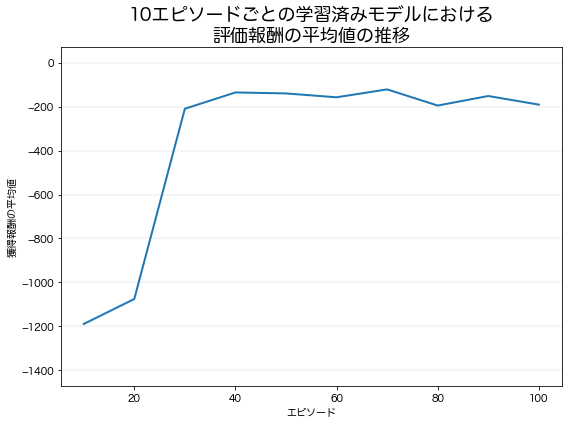

In [129]:
plt.figure(figsize=(8, 6), facecolor='white')
g = sns.lineplot(
    data=pd.DataFrame({
        'episode': range(args['eval_interval'], args['eval_interval'] * (len(eval_reward_list) + 1), args['eval_interval']),
        'reward': eval_reward_list
    }),
    x='episode', y='reward', lw=2
)
plt.title('{}エピソードごとの学習済みモデルにおける\n評価報酬の平均値の推移'.format(args['eval_interval']), fontsize=18, weight='bold')
plt.xlabel('エピソード')
plt.ylabel('獲得報酬の平均値')
for tick in plt.yticks()[0]:
    plt.axhline(tick, color='grey', alpha=0.1)
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('{}_eval_reward_{}.png'.format(gym_game_name, args['eval_interval'])), dpi=500)

## 学習済みモデルの検証

In [107]:
state = env.reset()
episode_reward = 0
done = False
while not done:
    with torch.no_grad():
        action = agent.select_action(state, evaluate=True)
    next_state, reward, done, _ = env.step(action)
    env.render()
    episode_reward += reward
    state = next_state
print('Reward: {:.2f}'.format(episode_reward))

Reward: -241.39


In [108]:
result = []
for experiment_name in ['agent', 'random']:
    for i in tqdm(range(100)):

        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            if experiment_name == 'agent':
                with torch.no_grad():
                    action = agent.select_action(state, evaluate=True)
            else:
                action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            state = next_state
        result.append([experiment_name, i, episode_reward])
result = pd.DataFrame(result, columns=['experiment_name', 'i', 'reward'])

100%|██████████| 100/100 [00:01<00:00, 56.35it/s]


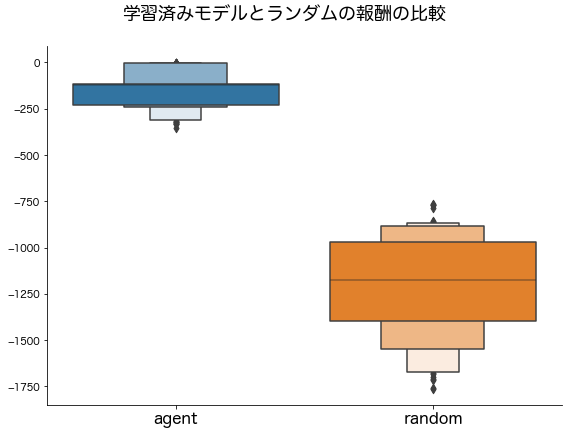

In [109]:
g = sns.catplot(data=result, x='experiment_name', y='reward', kind='boxen')
g.fig.suptitle('学習済みモデルとランダムの報酬の比較', fontsize=18, weight='bold', y=1.0)
g.fig.set_figwidth(8)
g.fig.set_figheight(6)
g.fig.set_facecolor('white')
g.set_xlabels('')
g.set_ylabels('')
g.set_xticklabels(fontsize=16)
g.tight_layout()
g.savefig(result_dir_path.joinpath(f'{gym_game_name}_reward_agent_vs_random.png'), dpi=500)

## 学習済みモデルのプレイを動画で保存し、GIF化する

In [115]:
from moviepy.editor import *
import warnings
warnings.filterwarnings('ignore')

In [111]:
video_dir_path = Path('video')
if not video_dir_path.exists():
    video_dir_path.mkdir(parents=True)

In [116]:
env = RecordVideo(
    gym.make(gym_game_name), video_folder=video_dir_path.__str__(), name_prefix=gym_game_name
)

state = env.reset()
episode_reward = 0
done = False
while not done:
    with torch.no_grad():
        action = agent.select_action(state, evaluate=True)
    next_state, reward, done, _ = env.step(action)
    env.render()
    episode_reward += reward
    state = next_state
print('Reward: {:.2f}'.format(episode_reward))
env.close()

Reward: -120.20


In [123]:
input_file_path = video_dir_path.joinpath(f'{gym_game_name}-episode-0.mp4')
output_file_path = video_dir_path.joinpath(f'{gym_game_name}-actor-critic.gif')
 
clip = VideoFileClip(input_file_path.__str__())
clip = clip.resize(width=600)
clip.write_gif(output_file_path.__str__(), fps=14)
clip.close()

MoviePy - Building file video/Pendulum-v1-actor-critic.gif with imageio.
